In [64]:
###################################
# Importing libraries and modules #
###################################

# Data Wrangling
import pandas as pd
import numpy as np
import collections
from scipy.stats import norm
import pandas_profiling

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import chart_studio.tools as tls
import chart_studio
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly_api_key import plotly_api_key

# Machine learning libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PowerTransformer #applies a power transformation to each feature to make the data more Gaussian-like.
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Library to balance targets
from imblearn.over_sampling import SMOTE
from collections import Counter


# Yellowbrick library
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import DiscriminationThreshold




In [2]:
# Downgrading matplotlib because of a bug resulting in truncated images
import matplotlib
matplotlib.__version__

'3.1.0'

In [3]:
chart_studio.tools.set_credentials_file(username='rogerlefort', api_key=plotly_api_key)

In [4]:
###################################
#        Data Preprocessing       #
###################################

In [51]:
# Opening dataset
play_by_play = pd.read_csv('resources/final_table_for_model_build.csv')
play_by_play.head()

,yardline_100,qtr,half_seconds_remaining,game_seconds_remaining,down,ydstogo,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,play_type,desc,temperature,snow,windspeed,visibility,humidity,precipitation
0,58.0,1,1793.0,3593.0,1.0,10,3.0,3.0,0.0,pass,Sunny,73,0.0,17,6,32,0.0
1,53.0,1,1756.0,3556.0,2.0,5,3.0,3.0,0.0,run,Sunny,73,0.0,17,6,32,0.0
2,56.0,1,1715.0,3515.0,3.0,8,3.0,3.0,0.0,pass,Sunny,73,0.0,17,6,32,0.0
3,56.0,1,1707.0,3507.0,4.0,8,3.0,3.0,0.0,punt,Sunny,73,0.0,17,6,32,0.0
4,98.0,1,1696.0,3496.0,1.0,10,3.0,3.0,0.0,run,Sunny,73,0.0,17,6,32,0.0


In [46]:
play_by_play.play_type.value_counts()

pass          186363
run           132668
no_play        24134
punt           23937
field_goal      9790
qb_kneel        3757
qb_spike         690
Name: play_type, dtype: int64

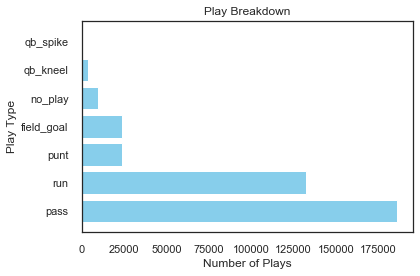

In [47]:
# Plotting play types
x_pos = play_by_play.play_type.unique()
y_values = play_by_play.play_type.value_counts()
plt.ylabel('Play Type')
plt.xlabel('Number of Plays')
plt.title('Play Breakdown')
plt.grid(False)
plt.barh(x_pos, y_values, color='SkyBlue')
plt.savefig('plots/play_breakdown_pre.png', dpi=600)
plt.tight_layout()
plt.show()

In [52]:
play_breakdown_all = go.Figure(data=[go.Pie(labels=x_pos, values=y_values, hole=.5)])

play_breakdown_all.update_layout(
#     title_text="Play Breakdown - All Plays",
    paper_bgcolor = 'rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)
play_breakdown_all.update_layout(
    legend=go.layout.Legend(
        x=-1,
        y=1,
        traceorder="normal",
        font=dict(
            family="Avenir",
            size=18,
            color="black"
        ),
#         bgcolor="LightSteelBlue",
#         bordercolor="Black",
#         borderwidth=2
    )
)
play_breakdown_all.show(renderer="iframe", width=500, height=500)
py.plot(play_breakdown_all, filename = 'play_breakdown_all', auto_open=False)

'https://plot.ly/~rogerlefort/110/'

For our analysis, we'll only consider passes, runs, punts and field goals.

In [53]:
only_productive_plays = play_by_play[(play_by_play.play_type == 'pass') | 
                                     (play_by_play.play_type == 'run') | 
                                     (play_by_play.play_type == 'punt') | 
                                    (play_by_play.play_type == 'field_goal')
                                    ] 
# Removing duplicates
only_productive_plays.drop_duplicates().head()

,yardline_100,qtr,half_seconds_remaining,game_seconds_remaining,down,ydstogo,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,play_type,desc,temperature,snow,windspeed,visibility,humidity,precipitation
0,58.0,1,1793.0,3593.0,1.0,10,3.0,3.0,0.0,pass,Sunny,73,0.0,17,6,32,0.0
1,53.0,1,1756.0,3556.0,2.0,5,3.0,3.0,0.0,run,Sunny,73,0.0,17,6,32,0.0
2,56.0,1,1715.0,3515.0,3.0,8,3.0,3.0,0.0,pass,Sunny,73,0.0,17,6,32,0.0
3,56.0,1,1707.0,3507.0,4.0,8,3.0,3.0,0.0,punt,Sunny,73,0.0,17,6,32,0.0
4,98.0,1,1696.0,3496.0,1.0,10,3.0,3.0,0.0,run,Sunny,73,0.0,17,6,32,0.0


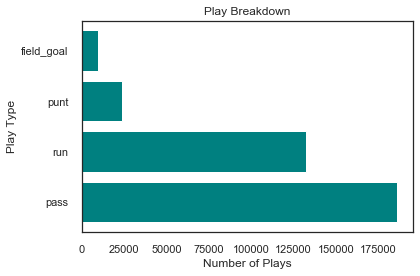

In [54]:
# Plotting play types with only passes and runs
x_pos = only_productive_plays.play_type.unique()
y_values = only_productive_plays.play_type.value_counts()
plt.ylabel('Play Type')
plt.xlabel('Number of Plays')
plt.title('Play Breakdown')
plt.grid(False)
plt.barh(x_pos, y_values, color='teal')
plt.tight_layout()
plt.savefig('plots/play_breakdown_some.png', dpi=600)
plt.show()

In [55]:
play_breakdown_some = go.Figure(data=[go.Pie(labels=x_pos, values=y_values, hole=.5)])

play_breakdown_some.update_layout(
#     title_text="Play Breakdown - All Plays",
    paper_bgcolor = 'rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)
play_breakdown_some.update_layout(
    legend=go.layout.Legend(
        x=-1,
        y=1,
        traceorder="normal",
        font=dict(
            family="Avenir",
            size=18,
            color="black"
        ),
#         bgcolor="LightSteelBlue",
#         bordercolor="Black",
#         borderwidth=2
    )
)
play_breakdown_some.show(renderer="iframe", width=500, height=500)
py.plot(play_breakdown_some, filename = 'play_breakdown_some', auto_open=False)

'https://plot.ly/~rogerlefort/113/'

In [10]:
# Selecting features
X = only_productive_plays.drop(columns=['play_type', 'desc'])
X.head()

,yardline_100,qtr,half_seconds_remaining,game_seconds_remaining,down,ydstogo,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,temperature,snow,windspeed,visibility,humidity,precipitation
0,58.0,1,1793.0,3593.0,1.0,10,3.0,3.0,0.0,73,0.0,17,6,32,0.0
1,53.0,1,1756.0,3556.0,2.0,5,3.0,3.0,0.0,73,0.0,17,6,32,0.0
2,56.0,1,1715.0,3515.0,3.0,8,3.0,3.0,0.0,73,0.0,17,6,32,0.0
3,56.0,1,1707.0,3507.0,4.0,8,3.0,3.0,0.0,73,0.0,17,6,32,0.0
4,98.0,1,1696.0,3496.0,1.0,10,3.0,3.0,0.0,73,0.0,17,6,32,0.0


In [11]:
# Selecting target
y = only_productive_plays.play_type
y.head()

0    pass
1     run
2    pass
3    punt
4     run
Name: play_type, dtype: object

In [12]:
print(X.shape)
print(y.shape)

(352758, 15)
(352758,)


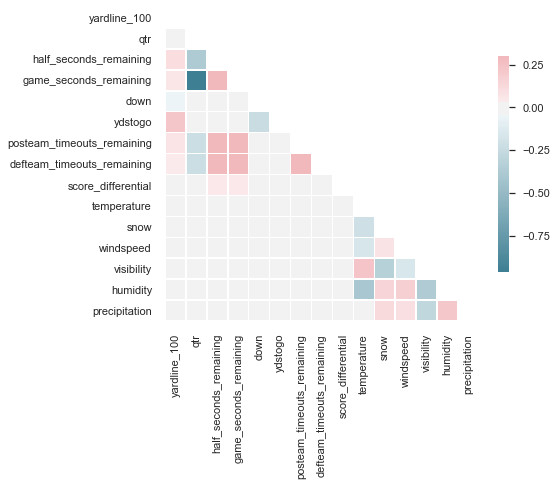

In [13]:
sns.set(style="white")

# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()
plt.savefig('plots/correlation_matrix.png', dpi=600, transparent=True)

In [14]:
########################################
#  FEATURE ENGINEERING AND SELECTION   #
########################################

In [15]:
##### Run only once as it takes a long time to process #########
# Comment code below to run 
#--------------------------------------------------------------#

# # With Pandas profiling we can get a complete profile of all the features
# feature_profile = X.profile_report()
# feature_profile.to_file(output_file="feature_profile_preprocessing.html")
# feature_profile

# # Checking for highly correlated feature_names
# rejected_variables = feature_profile.get_rejected_variables(threshold=0.8)
# rejected_variables

Our dataset does not contain any correlated features (Threshold=0.8)

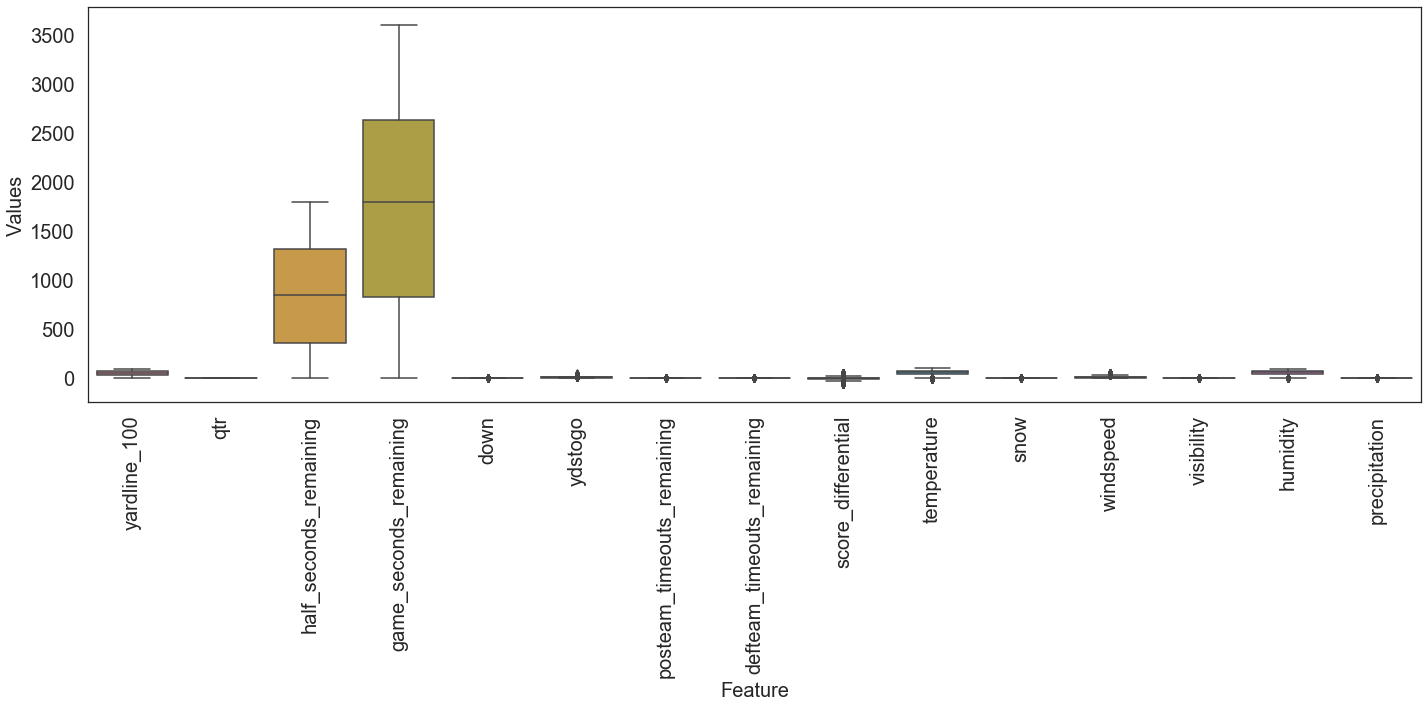

In [16]:
fig, ax = plt.subplots()
ax = sns.boxplot(x="variable", y="value", data=pd.melt(X))
fig.set_size_inches(20, 10)
ax.set_ylabel('Values', fontsize=20)
ax.set_xlabel('Feature', fontsize=20)
plt.tick_params(labelsize=20)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig('plots/box_plot.png', dpi=600)
plt.show()

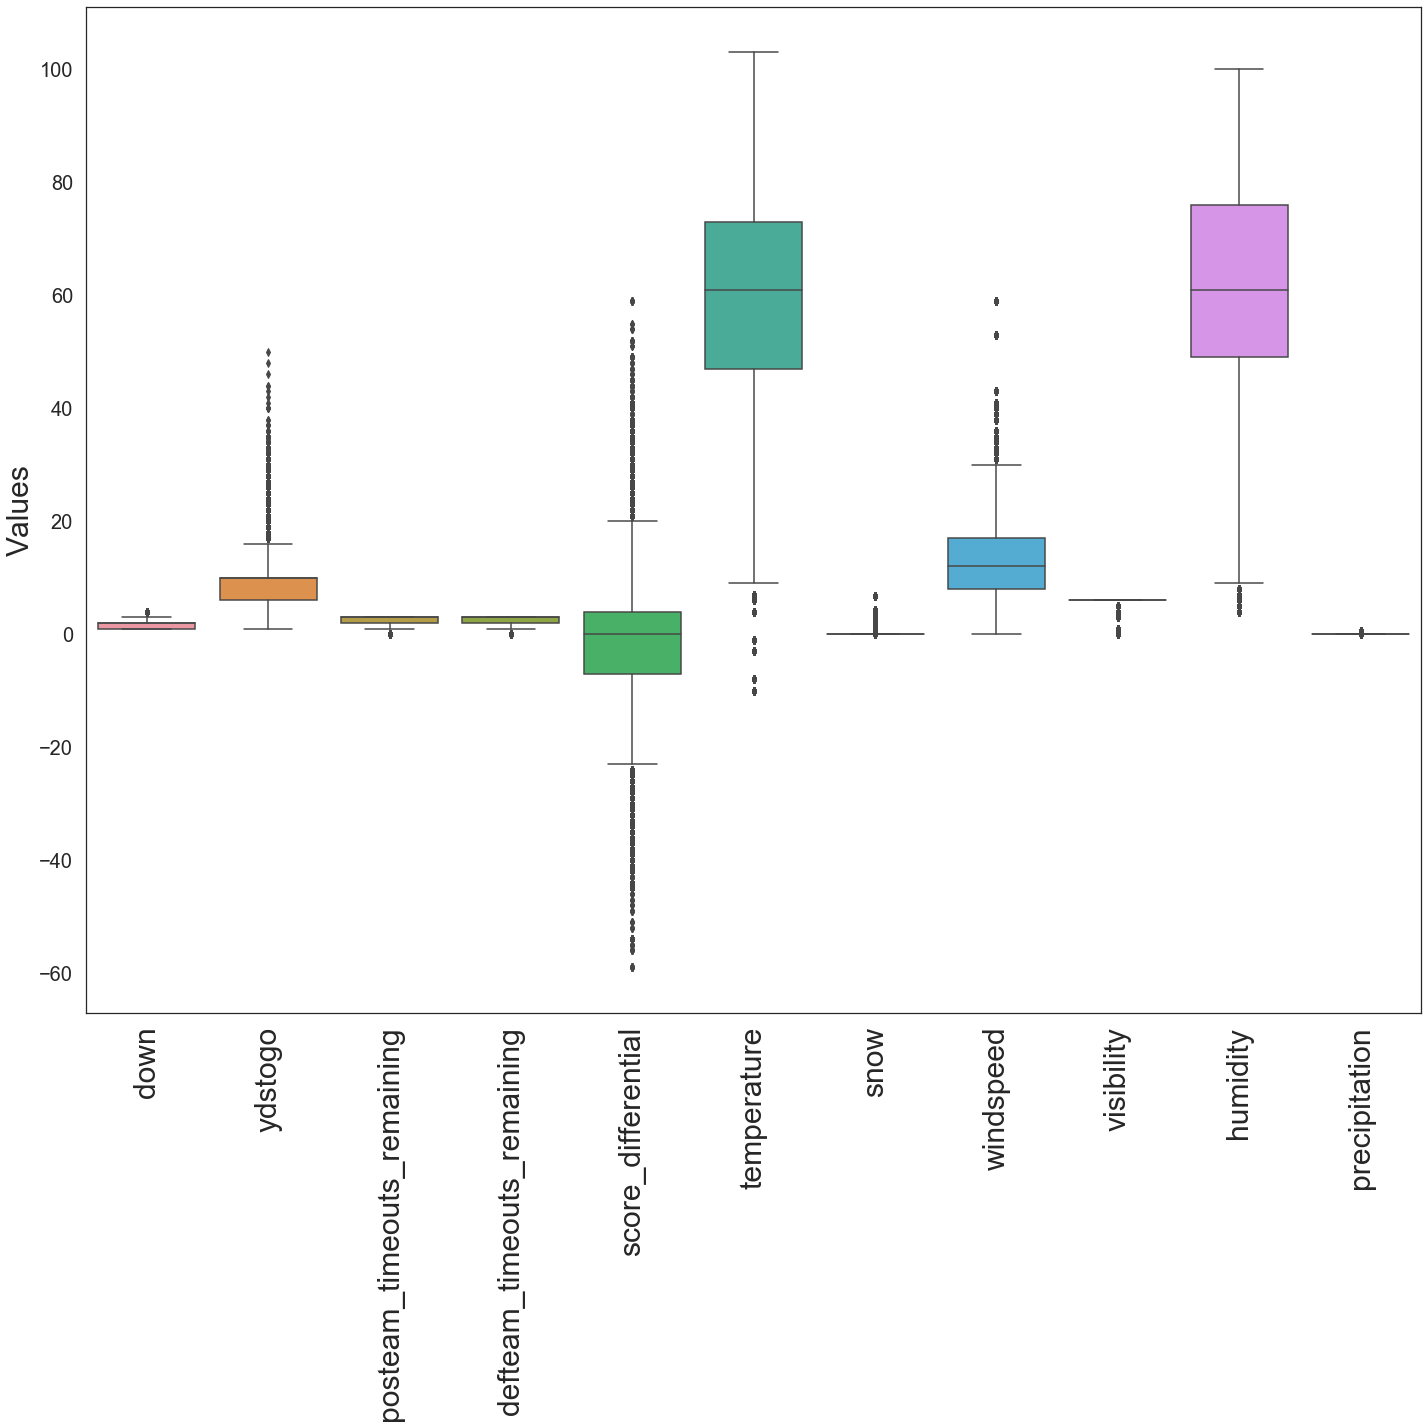

In [23]:
X_outliers = X.drop(columns=['half_seconds_remaining', 'game_seconds_remaining', 'yardline_100', 'qtr'])
fig, ax = plt.subplots()
ax = sns.boxplot(x="variable", y="value", data=pd.melt(X_outliers))
fig.set_size_inches(20, 20)
ax.set_ylabel('Values', fontsize=30)
ax.set_xlabel('', fontsize=30)
plt.tick_params(labelsize=20)
plt.xticks(rotation='vertical', fontsize=30)
plt.tight_layout()
plt.savefig('plots/box_plot_only_outliers.png', dpi=600, transparent=True)
plt.show()

A number of features contain outliers. All features will be transformed to account for outliers using power_transform

In [49]:
####################################
#     INITIAL MODEL EVALUATION     #
####################################

In [16]:
# Scaling data using powertransformer to minimize the effcts of outliers
pt = PowerTransformer()
pt.fit(X)
X_transformed = pt.transform(X)

In [17]:
# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state=42, stratify=y)

In [18]:
# Fitting XGB before visualizing with yellowbrick --IMPORTANT!
import xgboost as xgb
XGB_model = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
XGB_model.fit(X_train, y_train)
XGB_model.score(X_test ,y_test)

0.6819253883660279

In [19]:
models = [
    XGB_model,
    AdaBoostClassifier(random_state=1),
    SGDClassifier(max_iter=100, tol=1e-3), 
    KNeighborsClassifier(),
    LogisticRegression(solver='newton-cg'), 
    LogisticRegressionCV(cv=3),
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=200),
    tree.DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=300)
]

In [152]:
classifiers = ['XGBoost', 
               'AdaBoost', 
              'Stochastic Gradient Descent', 
              'K-Nearest Neighbor', 
              'Logistic Regression', 
               'Logistic RegressionCV', 
               'Bagging', 
               'Extra Tree', 
               'Decision Tree', 
               'Random Forest']

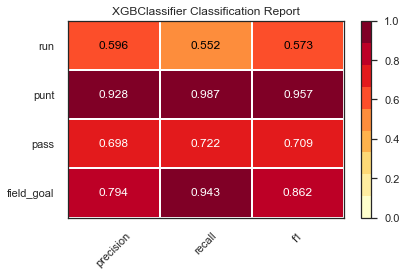

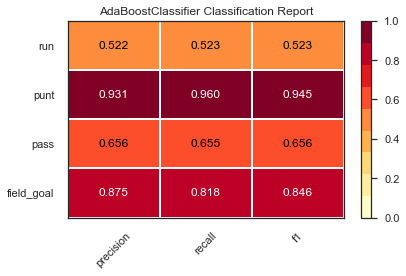

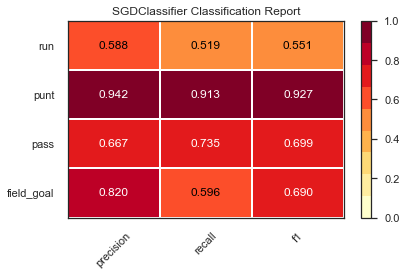

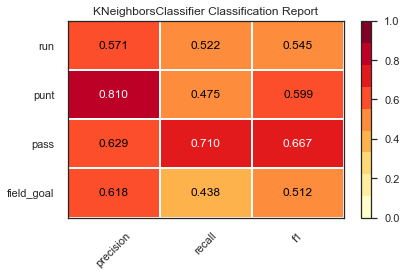

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning:

Line Search failed



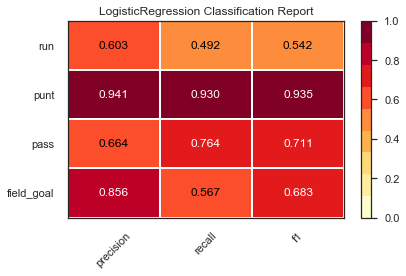

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



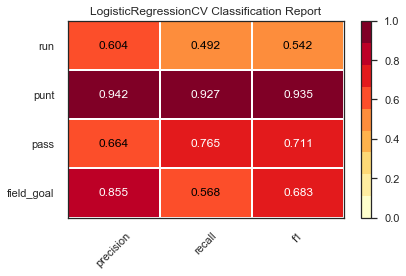

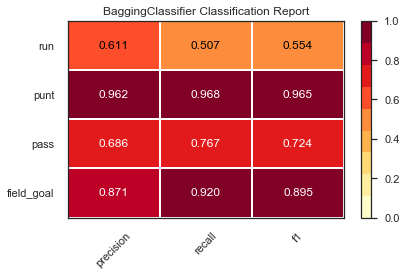

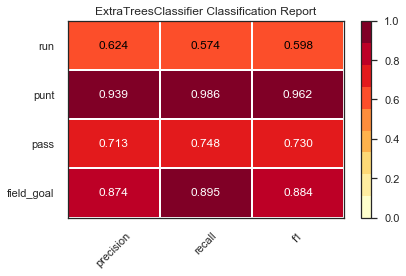

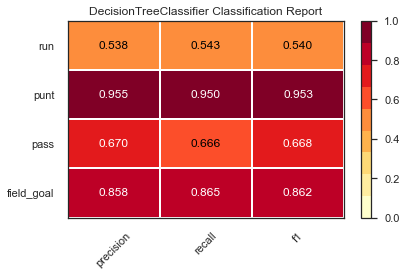

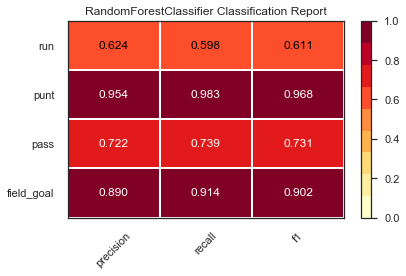

In [21]:
model_accuracy =[]
for estimator in models:
    model = ClassificationReport(estimator)
    model.fit(X_train, y_train)
    model.score(X_test, y_test)
    accuracy = model.score_
    model_accuracy.append(accuracy) 
    model.show()

In [22]:
model_accuracy

[0.6819253883660279,
 0.630797142533167,
 0.6617757115319197,
 0.6159088332010432,
 0.6677968023585441,
 0.6676607325093548,
 0.6870166685565257,
 0.702721396983785,
 0.6443134142192992,
 0.7078013380201837]

In [153]:
all_plays_model_df = pd.DataFrame()
all_plays_model_df['model'] = classifiers
all_plays_model_df['testing_accuracy'] = model_accuracy

In [154]:
all_plays_model_df.sort_values('testing_accuracy', ascending=False, inplace=True)

In [155]:
all_plays_model_df.testing_accuracy

9    0.707801
7    0.702721
6    0.687017
0    0.681925
4    0.667797
5    0.667661
2    0.661776
8    0.644313
1    0.630797
3    0.615909
Name: testing_accuracy, dtype: float64

In [156]:
colors = ['lightslategray',] * 10
colors[0] = 'crimson'

all_plays_model_accuracy = go.Figure(data=go.Bar(
            x=all_plays_model_df.testing_accuracy,
            y=all_plays_model_df.model,
            marker_color=colors,
            marker=dict(
            color='rgba(209,78,111,100)'),
            orientation='h')
               )

all_plays_model_accuracy.update_layout(
#     title_text="Testing Accuracy",
    xaxis_title="Accuracy Score",
    paper_bgcolor = 'rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

all_plays_model_accuracy.show(renderer="iframe", width=1000, height=800)
py.plot(all_plays_model_accuracy, filename = 'all_plays_model_accuracy', auto_open=True)

'https://plot.ly/~rogerlefort/108/'

In [253]:
models

[AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                    n_estimators=50, random_state=1),
 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='hinge',
               max_iter=100, n_iter_no_change=5, n_jobs=None, penalty='l2',
               power_t=0.5, random_state=None, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                      weights='uniform'),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_st

In [27]:
all_plays_model_df.to_json('resources/all_plays_model_df.json', orient='records')

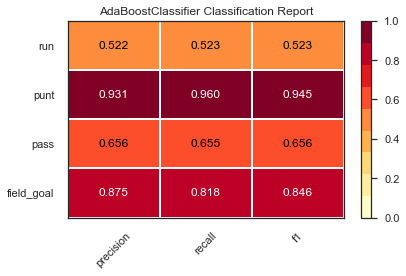

In [28]:
# AdaBoost
AdaB = ClassificationReport(AdaBoostClassifier(random_state=1))
AdaB.fit(X_train, y_train)
AdaB.score(X_test, y_test)
AdaB.show(outpath='model_reports/AdaB_all_plays.png', dpi=600, transparent=True)

In [158]:
AdaB.show(outpath='model_reports/AdaB_all_plays.svg')

<Figure size 432x288 with 0 Axes>

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning:

Line Search failed



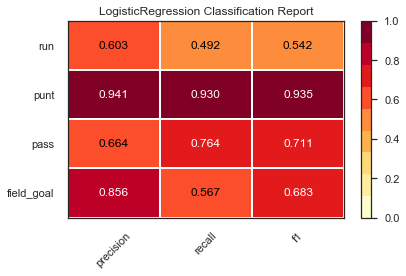

In [29]:
# Logistic regression
logreg = ClassificationReport(LogisticRegression(solver='newton-cg'))
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)
logreg.show(outpath='model_reports/logreg_all_plays.png', dpi=600, transparent=True)

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



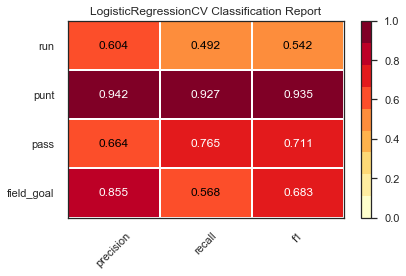

In [30]:
# Logistic regressionCV
logregCV = ClassificationReport(LogisticRegressionCV(cv=3))
logregCV.fit(X_train, y_train)
logregCV.score(X_test, y_test)
logregCV.show(outpath='model_reports/logregCV_all_plays.png', dpi=600, transparent=True)

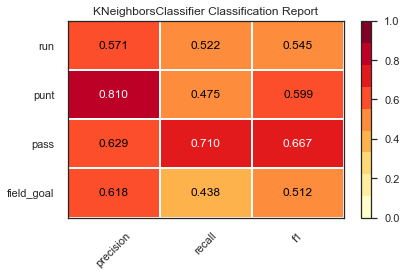

In [31]:
# K Nearest neighbor
knn = ClassificationReport(KNeighborsClassifier())
knn.fit(X_train, y_train)
knn.score(X_test, y_test)
knn.show(outpath='model_reports/knn_all_plays.png', dpi=600, transparent=True)

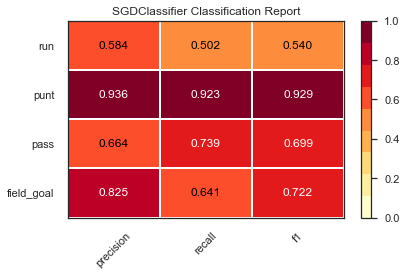

In [32]:
# SDG
sdg = ClassificationReport(SGDClassifier(max_iter=100, tol=1e-3))
sdg.fit(X_train, y_train)
sdg.score(X_test, y_test)
sdg.show(outpath='model_reports/sdg_all_plays.png', dpi=600, transparent=True)

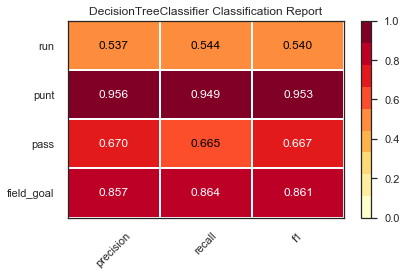

In [33]:
# Decision Tree
tree = ClassificationReport(tree.DecisionTreeClassifier())
tree.fit(X_train, y_train)
tree.score(X_test, y_test)
tree.show(outpath='model_reports/tree_all_plays.png', dpi=600, transparent=True)

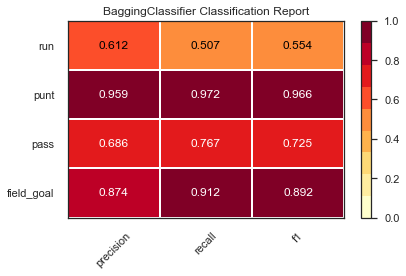

In [34]:
# Bagging
bag = ClassificationReport(BaggingClassifier())
bag.fit(X_train, y_train)
bag.score(X_test, y_test)
bag.show(outpath='model_reports/bag_all_plays.png', dpi=600, transparent=True)

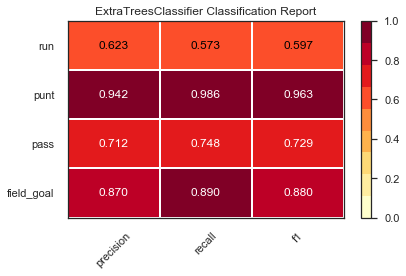

In [35]:
# Extra tree
extree = ClassificationReport(ExtraTreesClassifier(n_estimators=200))
extree.fit(X_train, y_train)
extree.score(X_test, y_test)
extree.show(outpath='model_reports/extree_all_plays.png', dpi=600, transparent=True)

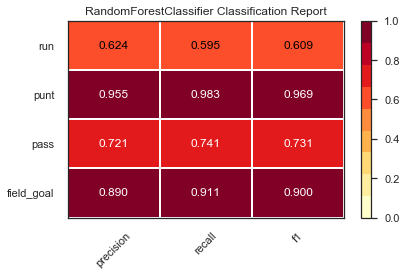

In [161]:
# Random Forrest
forrest = ClassificationReport(RandomForestClassifier(n_estimators=300))
forrest.fit(X_train, y_train)
forrest.score(X_test, y_test)
forrest.show(outpath='model_reports/forrest_all_plays.png', dpi=600, transparent=True)

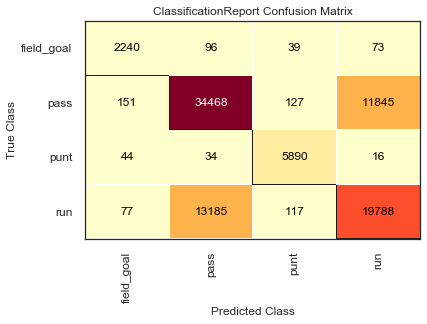

In [159]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(forrest)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show(outpath='model_reports/forrest_cm_all_plays.png', dpi=600, transparent=True)

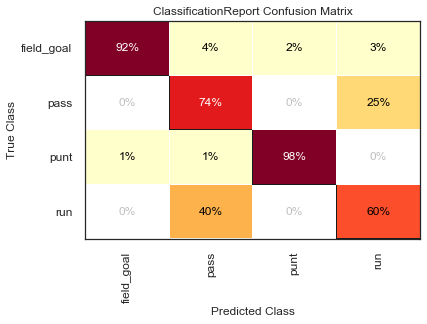

In [160]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(forrest, percent=True)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show(outpath='model_reports/forrest_cm_all_plays_percent.png', dpi=600, transparent=True)

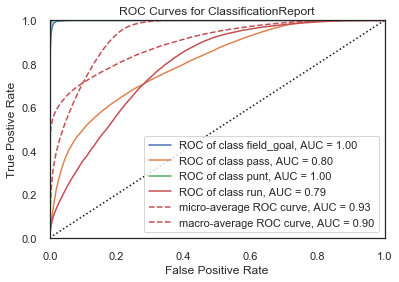

In [162]:
# Instantiate the visualizer with the classification model
visualizer = ROCAUC(forrest)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show(outpath='model_reports/forrest_ROCAUC_all_plays.png', dpi=600, transparent=True) # Finalize and show the figure

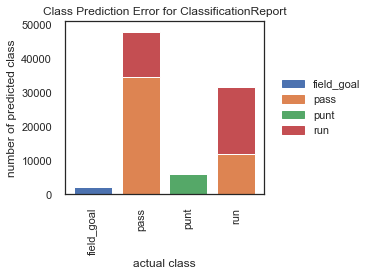

In [165]:
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(forrest)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show(outpath='model_reports/forrest_pred_error_all_plays.png', dpi=600, transparent=True)

In [38]:
# import xgboost as xgb
# XGB_model = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
# XGB_model.fit(X_train, y_train)
# XGB_model.score(X_test ,y_test)

# XGB_model_train_score = XGB_model.score(X_train, y_train)
# XGB_model_test_score = XGB_model.score(X_test, y_test)
# print(f"Training Data Score: {XGB_model_train_score}")
# print(f"Testing Data Score: {XGB_model_test_score}")

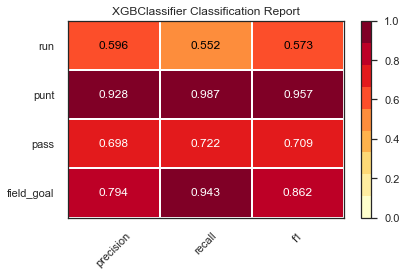

In [39]:
# XGBoost
XGb = ClassificationReport(XGB_model)
XGb.fit(X_train, y_train)
XGb.score(X_test, y_test)
XGb.show(outpath='model_reports/xgb_all_plays.svg')

In [ ]:
####################################
#          Balancing dataset       #
####################################

In [40]:
# applying SMOTE to our data and checking the class counts
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(X_resampled.shape)
print(y_resampled.shape)


pt = PowerTransformer()
pt.fit(X_resampled)
X_resampled_transformed = pt.transform(X_resampled)
print(sorted(Counter(y_resampled).items()))

print(X_resampled_transformed.shape)
print(y_resampled.shape)
collections.Counter(y_resampled)


(745452, 15)
(745452,)
[('field_goal', 186363), ('pass', 186363), ('punt', 186363), ('run', 186363)]
(745452, 15)
(745452,)


Counter({'pass': 186363, 'run': 186363, 'punt': 186363, 'field_goal': 186363})

In [66]:
# Splitting resampled data into training and testing
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled_transformed, y_resampled, random_state=42)

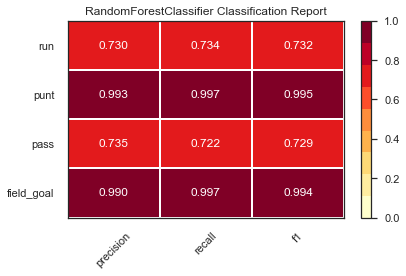

In [67]:
# Random Forrest
res_forrest = ClassificationReport(RandomForestClassifier(n_estimators=300))
res_forrest.fit(X_train_resampled, y_train_resampled)
res_forrest.score(X_test_resampled, y_test_resampled)
res_forrest.show(outpath='model_reports/forrest_resampled_all_plays.svg')

In [137]:
print(res_forrest.score_)
print(forrest.score_)

0.8629180685007217
0.707404467626715


In [142]:
# Graphing accuracy score before and after balancing dataset
random_forrest_df = pd.DataFrame()
random_forrest_df['attr'] = ['Imbalanced Classes', 'Resampled Classes']
random_forrest_df['accuracy_score'] = [res_forrest.score_, forrest.score_]

In [147]:
random_forrest_df

,attr,accuracy_score
0,Imbalanced Classes,0.862918
1,Resampled Classes,0.707404


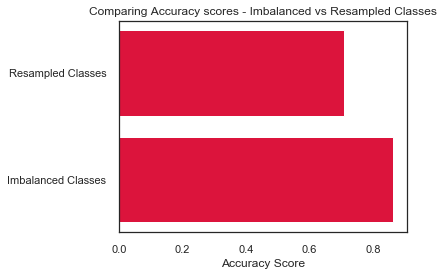

In [150]:
# Plotting accuracy scores
x_pos = random_forrest_df.accuracy_score
y_values = random_forrest_df.attr
# plt.ylabel('Play Type')
plt.xlabel('Accuracy Score')
plt.title('Comparing Accuracy scores - Imbalanced vs Resampled Classes')
plt.grid(False)
plt.barh(y_values, x_pos, color='crimson')
plt.tight_layout()
plt.savefig('plots/random_forest_accuracy_scores_before_after_resampling.png', dpi=600, transparent=True)
plt.show()

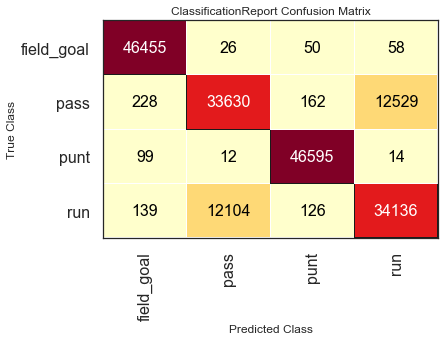

In [68]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(res_forrest, fontsize=16)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_resampled, y_train_resampled)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test_resampled, y_test_resampled)

# How did we do?
cm.show(outpath='model_reports/forrest_resampled_cm_all_plays', dpi=600, transparent=True)


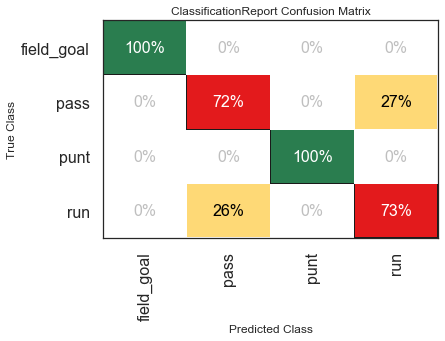

In [69]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(res_forrest, percent=True, fontsize=16)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_resampled, y_train_resampled)

# Creates the confusion_matrix from scikit-learn.
cm.score(X_test_resampled, y_test_resampled)

# Performance?
cm.show(outpath='model_reports/forrest_resampled_cm_percent_all_plays', dpi=600, transparent=True)

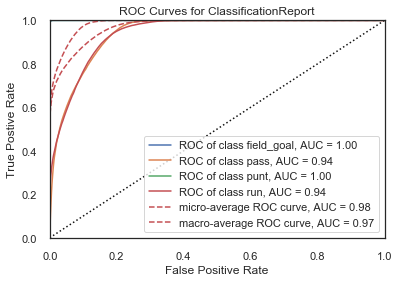

In [70]:
# Instantiate the visualizer with the classification model
visualizer = ROCAUC(res_forrest)

visualizer.fit(X_train_resampled, y_train_resampled)        # Fit the training data to the visualizer
visualizer.score(X_test_resampled, y_test_resampled)        # Evaluate the model on the test data
visualizer.show(outpath='model_reports/forrest_resampled_ROCAUC_all_plays', dpi=600, transparent=True) # Finalize and show the figure

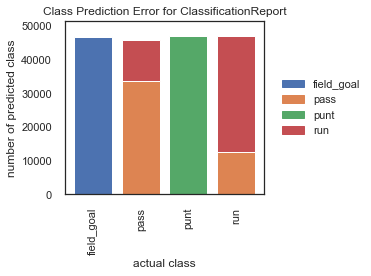

In [71]:
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(res_forrest)

# Fit the training data to the visualizer
visualizer.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test data
visualizer.score(X_test_resampled, y_test_resampled)

# Draw visualization
visualizer.show(outpath='model_reports/forrest_resampled_pred_error_all_plays', dpi=600, transparent=True)

In [72]:
################################
# SELECTING IMPORTANT FEATURES #
################################

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in versi

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in versi

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in versi

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/Users/rogerlefort/anaconda3/envs/nflData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in versi

Optimal number of features: 7


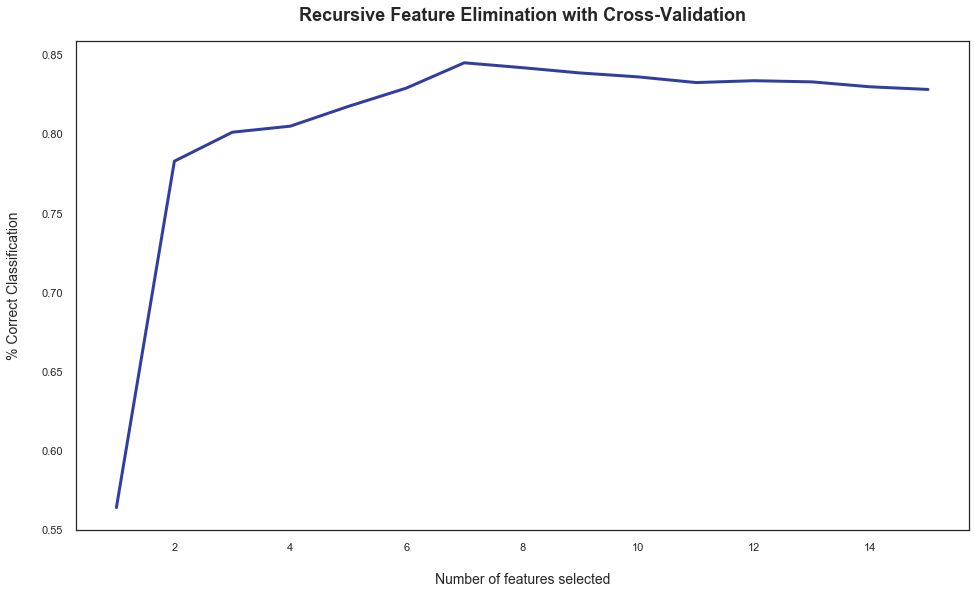

In [73]:
rfc = RandomForestClassifier(random_state=300)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X_resampled_transformed, y_resampled)

print('Optimal number of features: {}'.format(rfecv.n_features_))

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.savefig('plots/RFECV_resampled_all_plays.png', dpi=600)
plt.show()

In [74]:
print(np.where(rfecv.support_ == False)[0])

[ 1  6  7  9 10 11 12 14]


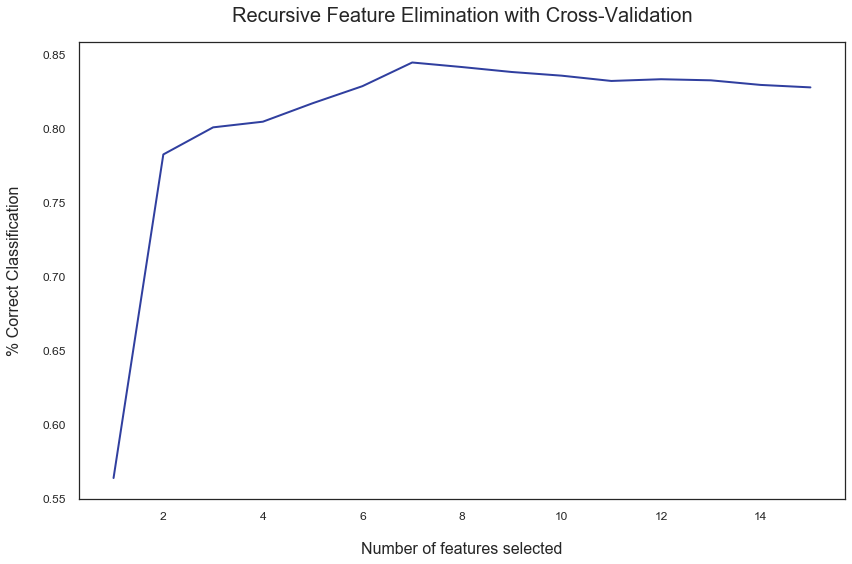

In [131]:
plt.figure(figsize=(12, 8))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=20, pad=20)
plt.xlabel('Number of features selected', fontsize=16, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=16, labelpad=20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=2)
plt.tight_layout()
plt.savefig('plots/RFECV_all_plays.png', dpi=600, transparent=True)
plt.show()

In [88]:
rfecv_plot_all_plays = go.Figure(go.Scatter(
    x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    y=rfecv.grid_scores_
))

rfecv_plot_all_plays.update_layout(
    title_text="Recursive Feature Elimination with Cross-Validation",
    xaxis_title="Number of Features Selected",
    yaxis_title="% Correct Classification",
    paper_bgcolor = 'rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

# rfecv_plot.update_layout(
#     legend=go.layout.Legend(
#         x=0,
#         y=1,
#         traceorder="normal",
#         font=dict(
#             family="Avenir",
#             size=18,
#             color="black"
#         ),
#         bgcolor="LightSteelBlue",
#         bordercolor="Black",
#         borderwidth=2
#     )
# )
rfecv_plot_all_plays.show(renderer="iframe", width=1200, height=800)
py.plot(rfecv_plot_all_plays, filename = 'rfecv_plot_all_plays', auto_open=True)

'https://plot.ly/~rogerlefort/115/'

In [122]:
rfecv.estimator_.feature_importances_

array([0.30857499, 0.09123255, 0.06986224, 0.35910844, 0.069851  ,
       0.04764744, 0.05372334])

In [77]:
non_impotant_features = np.where(rfecv.support_ == False)[0]
print(non_impotant_features)

[ 1  6  7  9 10 11 12 14]


In [78]:
X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

In [79]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_


In [80]:
dset = dset.sort_values(by='importance', ascending=False)
dset.head()

,attr,importance
3,down,0.359108
0,yardline_100,0.308575
1,half_seconds_remaining,0.091233
2,game_seconds_remaining,0.069862
4,ydstogo,0.069851


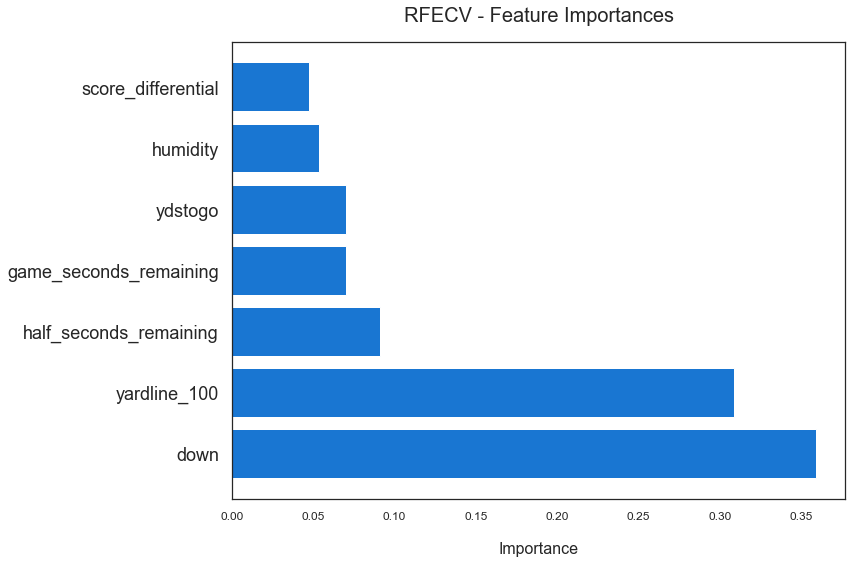

In [132]:
plt.figure(figsize=(12, 8))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
ax.tick_params(labelsize=14)
plt.title('RFECV - Feature Importances', fontsize=20, pad=20)
plt.xlabel('Importance', fontsize=16, labelpad=20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 18)
plt.tight_layout()
plt.savefig('plots/important_features_all_plays.png', dpi=600, transparent=True)
plt.show()

In [112]:
dset.dtypes

attr           object
importance    float64
dtype: object

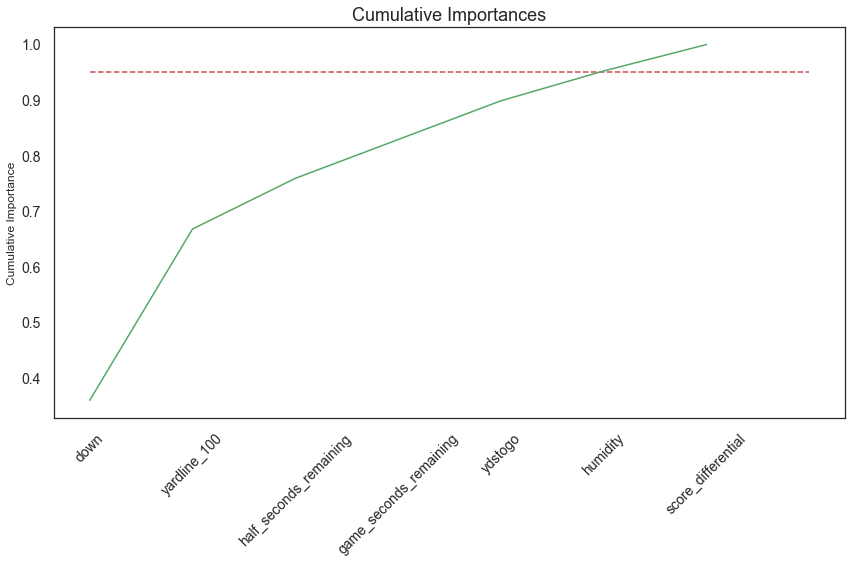

In [129]:
plt.figure(figsize=(12, 8))
# List of features sorted from most to least important
# sorted_importances = [importance[1] for importance in dset.importance]
# sorted_features = [importance[0] for importance in dset.importance]
# Cumulative importances
cumulative_importances = np.cumsum(dset.importance)
# Make a line graph
plt.plot(dset.attr, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(dset.attr), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(dset.attr, rotation = 45, fontsize = 14)
# Axis labels and title
plt.ylabel('Cumulative Importance'); 
plt.title('Cumulative Importances', fontsize = 18)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.savefig('plots/cum_important_features_all_plays.png', dpi=600, transparent=True)
plt.show()

In [87]:
# fig = go.Figure()

rfecv_features_all_plays = go.Figure(data=go.Bar(
            x=dset['importance'],
            y=dset['attr'],
            marker=dict(
                color='rgba(8,80,111,100)'),
            orientation='h')
               )

rfecv_features_all_plays.update_layout(
    title_text="RFECV - Feature Importances",
    xaxis_title="Importance Score",
    paper_bgcolor = 'rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

rfecv_features_all_plays.show(renderer="iframe", width=1200, height=800)
py.plot(rfecv_features_all_plays, filename = 'rfecv_features_all_plays', auto_open=False)

'https://plot.ly/~rogerlefort/117/'

In [84]:
#################################################################
# Saving selected dataset after removing non-important features
X_selected = X.copy()
X_selected.to_csv('X_selected_all_plays.csv', index=False)
#################################################################
# Saving selected targets to match naming structure
y_selected = y.copy()
y_selected.to_csv('y_selected_plays.csv', header=True, index=False)

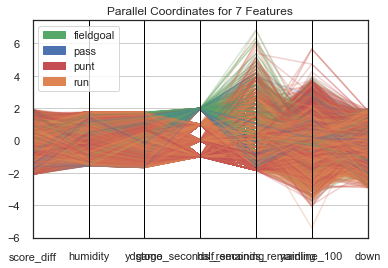

In [86]:
# Visualizing feature importance on final dataset
from yellowbrick.features import ParallelCoordinates
from yellowbrick.datasets import load_occupancy

# Load the classification data set
X_resampled, y_resampled = load_occupancy()

# Specify the features of interest and the classes of the target
features = ['score_diff', 'humidity', 'ydstogo', 'game_seconds_remaining', 'half_seconds_remaining', 'yardline_100', 'down']
classes = ['pass', 'run', 'fieldgoal', 'punt']

# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features,
    normalize='standard', sample=0.05, shuffle=True,
)

# Fit the visualizer and display it
visualizer.fit_transform(X_selected, y_selected)
visualizer.show(outpath='plots/ParallelCoordinates_all_plays.png', dpi=600, transparent=True)

In [ ]:
####################################
#    OPTIMIZED MODEL EVALUATION    #
####################################

In [89]:
X_selected

,yardline_100,half_seconds_remaining,game_seconds_remaining,down,ydstogo,score_differential,humidity
0,58.0,1793.0,3593.0,1.0,10,0.0,32
1,53.0,1756.0,3556.0,2.0,5,0.0,32
2,56.0,1715.0,3515.0,3.0,8,0.0,32
3,56.0,1707.0,3507.0,4.0,8,0.0,32
4,98.0,1696.0,3496.0,1.0,10,0.0,32
...,...,...,...,...,...,...,...
381332,71.0,82.0,82.0,2.0,1,-5.0,53
381333,71.0,77.0,77.0,3.0,1,-5.0,53
381335,66.0,63.0,63.0,2.0,10,-5.0,53
381336,66.0,58.0,58.0,3.0,10,-5.0,53


In [90]:
y_selected

0         pass
1          run
2         pass
3         punt
4          run
          ... 
381332    pass
381333    pass
381335    pass
381336    pass
381337    pass
Name: play_type, Length: 352758, dtype: object

In [92]:
print(X_selected.shape)
print(y_selected.shape)

(352758, 7)
(352758,)


#### SUMMARY

1. Target classes were balanced for equal sampling of pass and run
2. Feature set was reduced from 15 to 7 using RFECV method on balanced data
3. Renamed new feature and target datasets as X_selected and y_selected 

*Note: X_selected and y_selected are not balanced*

In [ ]:
# X.dtypes

In [ ]:
# # Converting some down and qtr features to categorical
# X.down = X.down.astype(str)
# X.qtr = X.qtr.astype(str)

In [ ]:
# X.dtypes

In [ ]:
# # Encoding categorical features
# # Categorical boolean mask
# categorical_feature_mask = X.dtypes==object
# # filter categorical columns using mask and turn it into a list
# categorical_cols = X.columns[categorical_feature_mask].tolist()
# categorical_cols

In [ ]:
# # Instantiate labelencoder object
# le = LabelEncoder()
# # Apply le on categorical feature columns
# X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))
# X[categorical_cols].head(10)

In [ ]:
# # Instantiate OneHotEncoder
# ohe = OneHotEncoder(categorical_features = categorical_feature_mask, sparse=False ) 
# # categorical_features = boolean mask for categorical columns
# # sparse = False output an array not sparse matrix

In [ ]:
# # apply OneHotEncoder on categorical feature columns
# X_ohe = ohe.fit_transform(X) # It returns an numpy array

In [ ]:
# X_ohe

In [ ]:
# rfc = RandomForestClassifier(random_state=100)
# rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
# rfecv.fit(X_ohe, y)

# print('Optimal number of features: {}'.format(rfecv.n_features_))

# plt.figure(figsize=(16, 9))
# plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
# plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
# plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
# plt.savefig('plots/RFECV.png', dpi=600)
# plt.show()

In [ ]:
# print(np.where(rfecv.support_ == False)[0])

In [ ]:
# rfecv.estimator_.feature_importances_

In [ ]:
# X.columns

In [ ]:
# dset = pd.DataFrame()
# dset['attr'] = X_ohe.columns
# dset['importance'] = rfecv.estimator_.feature_importances_

# # dset = dset.sort_values(by='importance', ascending=False)
# # dset.head()

In [ ]:
# plt.figure(figsize=(16, 14))
# plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
# plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
# plt.xlabel('Importance', fontsize=14, labelpad=20)
# plt.savefig('plots/important_features.png', dpi=600)
# plt.show()

In [ ]:
# transformed = np.cbrt(play_by_play.precipitation)

In [ ]:
# transformed